**Title: Star Classification**

**Introduction**

There are billions of stars in our sky and every star is unique. There are Brown, White, and Red dwarfs, Main sequence stars like the sun and also Hyper and Super giants. Each of these star types has unique characteristics which can be used to classify their type. Astronomers typically use features such as the stars Luminosity, Radius, and Temperature to determine its type. In this data analysis, we will look at a star dataset which includes features of 240 stars which includes 40 stars from each of the 6 categories. The dataset contains various features of stars but the ones useful to us for this data analysis are star type, luminosity, radius, and temperature. Luminosity is the amount of energy generated per second by the star and is given in stellar units. This means that a luminosity of 100 means 100 times more luminous than the sun. Stellar units also apply for the radius. Researchers have used the Hertzsprung-Russell Diagram (Luminosity vs. Temperature) to plot star features in order to determine a star’s type. To further our understanding of this diagram, we want to utilize k-nn classification to imitate aspects of the diagram and predict a new star’s type. The question we will address is whether we can build a model which effectively, consistently, and accurately classifies a new star’s type using k-nn classification to classify stars based on the luminosity, radius, and temperature.

**Methods & Results**

In this data analysis, the plan is to build a model using temperature, radius, and luminosity. To start off we will set our seed value and load in all the libraries we need for this data analysis

In [1]:
#Load all libraries and set plot dimensions  
set.seed(202)
options(repr.plot.height = 8, repr.plot.width = 10)
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Load Dataset**

Now we need to load our dataset and analyze it by looking at first and last 6 observations using tail and head functions.

In [2]:
#Load data frame and changed the column names to more convenient   
url <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vR0bAqJh1jznOVyOZbHPL3kLbFjX6YzCWwMh3vMZEeBZq95tdDfcN9vqDP6XUf2j167vXr4oxnDvhb4/pub?gid=1536482276&single=true&output=csv"
star <- read_csv(url)

head(star)
tail(star)

Parsed with column specification:
cols(
  `Temperature (K)` = col_double(),
  `Luminosity(L/Lo)` = col_double(),
  `Radius(R/Ro)` = col_double(),
  `Absolute magnitude(Mv)` = col_double(),
  `Star type` = col_double(),
  `Star color` = col_character(),
  `Spectral Class` = col_character()
)



Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3068,0.002400,0.1700,16.12,0,Red,M
3042,0.000500,0.1542,16.60,0,Red,M
2600,0.000300,0.1020,18.70,0,Red,M
2800,0.000200,0.1600,16.65,0,Red,M
1939,0.000138,0.1030,20.06,0,Red,M
2840,0.000650,0.1100,16.98,0,Red,M


Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
21904,748490,1130,-7.67,5,Blue-white,B
38940,374830,1356,-9.93,5,Blue,O
30839,834042,1194,-10.63,5,Blue,O
8829,537493,1423,-10.73,5,White,A
9235,404940,1112,-11.23,5,White,A
37882,294903,1783,-7.80,5,Blue,O


**Clean and Wrangle Dataset**

Uploading the raw dataset yielded column names that were difficult to apply functions to. Thus, we utilized underscores to make the column names more convenient. Our target variable, star_type, was changed to a factor. The default star_type levels were numbers, which do not accurately represent qualitative star types. Using the metadata from the original dataset, we updated the star_type levels accordingly. A log10 function was applied to all predictors, as the predictors had vastly different ranges. This could improve our exploratory visualization in understanding which predictors to use.

In [3]:
#Rename columns to more convenient name
star_data <- star %>% 
    rename(star_type = "Star type",
           star_color = "Star color",
           spectral_class = "Spectral Class",
           temperature = "Temperature (K)",
           radius = "Radius(R/Ro)",
           luminosity = "Luminosity(L/Lo)",
           absolute_magnitude = "Absolute magnitude(Mv)") %>%
    tibble()


#Renamed numerical values of star type to their actual name 
star_data$star_type[star_data$star_type == 0] <- "Brown Dwarf"
star_data$star_type[star_data$star_type == 1] <- "Red Dwarf"
star_data$star_type[star_data$star_type == 2] <- "White Dwarf"
star_data$star_type[star_data$star_type == 3] <- "Main Sequence"
star_data$star_type[star_data$star_type == 4] <- "Super Giant"
star_data$star_type[star_data$star_type == 5] <- "Hyper Giant"

#Changed star_type to a factor and also applied log10 function to all predictors
star_data <- star_data %>%
    mutate(star_type = as_factor(star_type),
          luminosity = log10(luminosity),
          radius = log10(radius),
          temperature = log10(temperature))

Since we will be performing a knn classification, before doing any exploratory data analysis of our data we only want access to the training dataset and we want to hide the test dataset. So let’s split our dataset by using 60% of original dataset for the training set and 40% for the test set so we can have a fairly good balance between building an accurate model and have a large enough test dataset so we can get a precise accuracy for our model.

In [4]:
#Split the data into a training set and testing set 
star_split <- initial_split(star_data, prop = 0.6, strata = star_type)
star_train <- training(star_split)
star_test <- testing(star_split)

**Exploratory Data Analysis: Dataset Summary**

We can summarize the dataset by getting the average temperature, density and radius for each star type.

In [5]:
#Plot indicating the number of observations in each star type and averages of all predictor variables
star_distribution <- star_train %>%
    select(temperature, radius, luminosity, star_type) %>%
    group_by(star_type) %>%
    summarize(stars_in_class = n(), luminosity_avg = mean(luminosity), radius_avg = mean(radius), temperature_avg = mean(temperature))

star_distribution

`summarise()` ungrouping output (override with `.groups` argument)



star_type,stars_in_class,luminosity_avg,radius_avg,temperature_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>
Brown Dwarf,24,-3.395276,-0.9552217,3.462311
Red Dwarf,24,-2.626064,-0.4827951,3.510692
White Dwarf,24,-3.115191,-1.9699895,4.141493
Main Sequence,24,2.093466,0.4380121,4.059024
Super Giant,24,5.418329,1.6316223,4.108917
Hyper Giant,24,5.412320,3.1225968,3.854569


**Table 1**

In Table 1, 24 observations exist for each star type. Here, we see indications of large variability in temperature hinting that temperature may not be an effective predictor.

**Exploratory Data Analysis: Visualizations**

Creating three different visualizations of the predictors, it was realized that temperature may not be an effective predictor. A histogram, showing temperature distribution for the star types, will help in our understanding of the dataset.

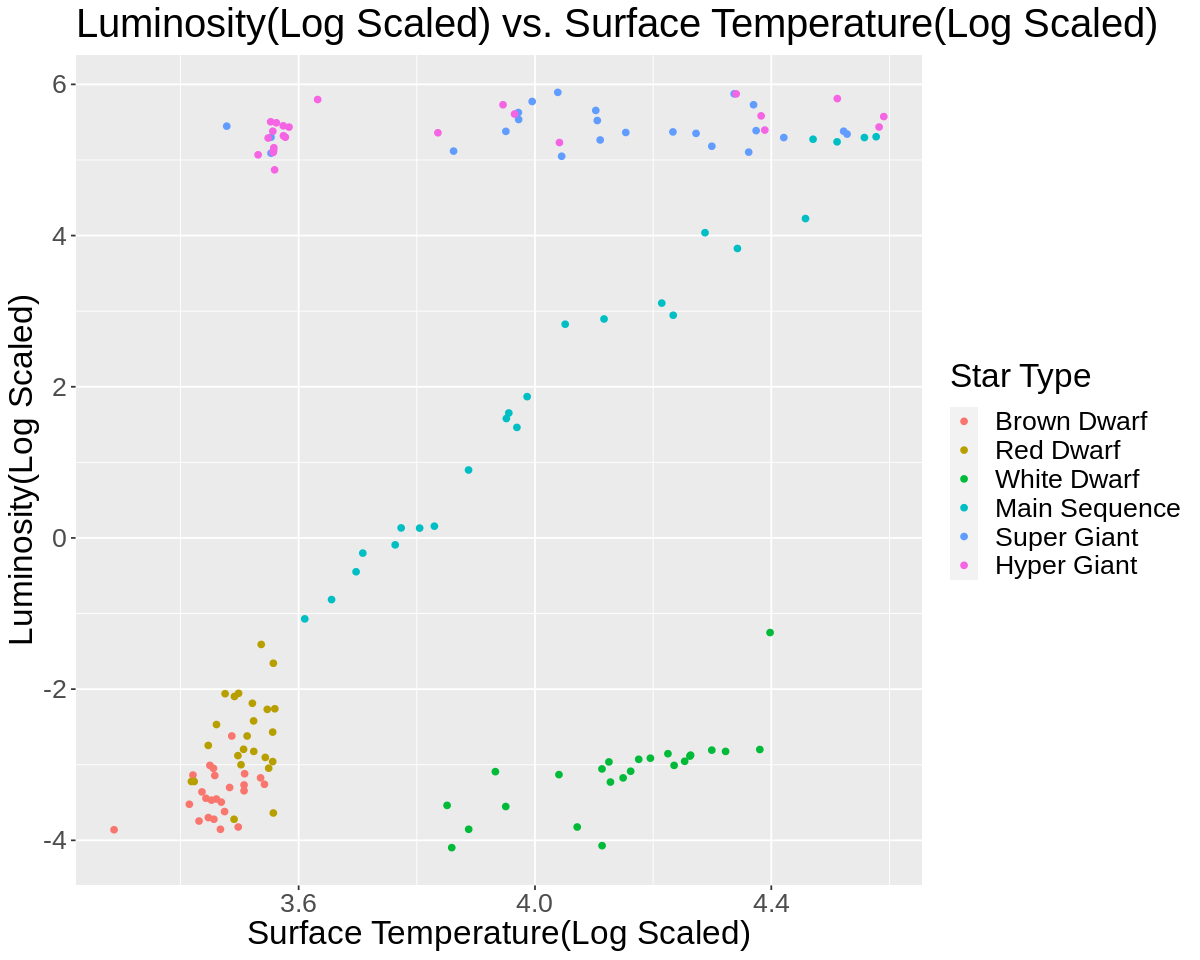

In [6]:
#Visualization of Luminosity vs. Temperature
star_plot <- star_train %>%
    ggplot(aes(x = temperature, y = luminosity, color = star_type)) + 
    geom_point() +
    ggtitle("Luminosity(Log Scaled) vs. Surface Temperature(Log Scaled)") +
    labs(x = "Surface Temperature(Log Scaled)", y = "Luminosity(Log Scaled)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot

**Figure 1**

Luminosity and temperature seem to have multiple relationships going on. For Main Sequence Stars, Red dwarfs, and Brown dwarfs, there is a strong positive linear relationship and there seems to be a moderate positive relationship for White Dwarfs and Hyper Giants and Super Giants don't have a relationship at all.

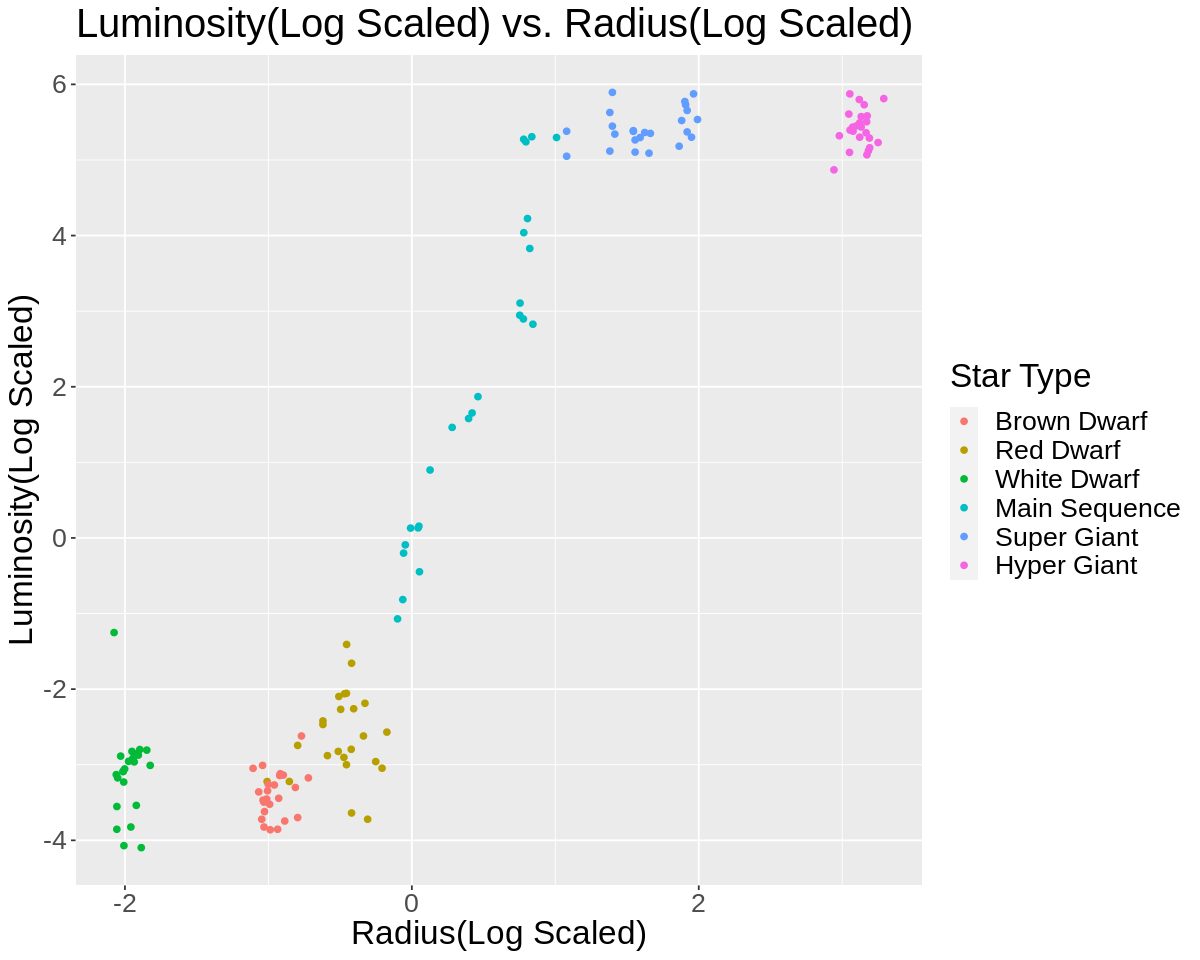

In [7]:
#Visualization of Luminosity vs. Radius
star_plot_2 <- star_train %>%
    ggplot(aes(x = radius, y = luminosity, color = star_type)) + 
    geom_point() +
    ggtitle("Luminosity(Log Scaled) vs. Radius(Log Scaled)") +
    labs(x = "Radius(Log Scaled)", y = "Luminosity(Log Scaled)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot_2

**Figure 2**

Luminosity and Radius have a strong positive non-linear relationship

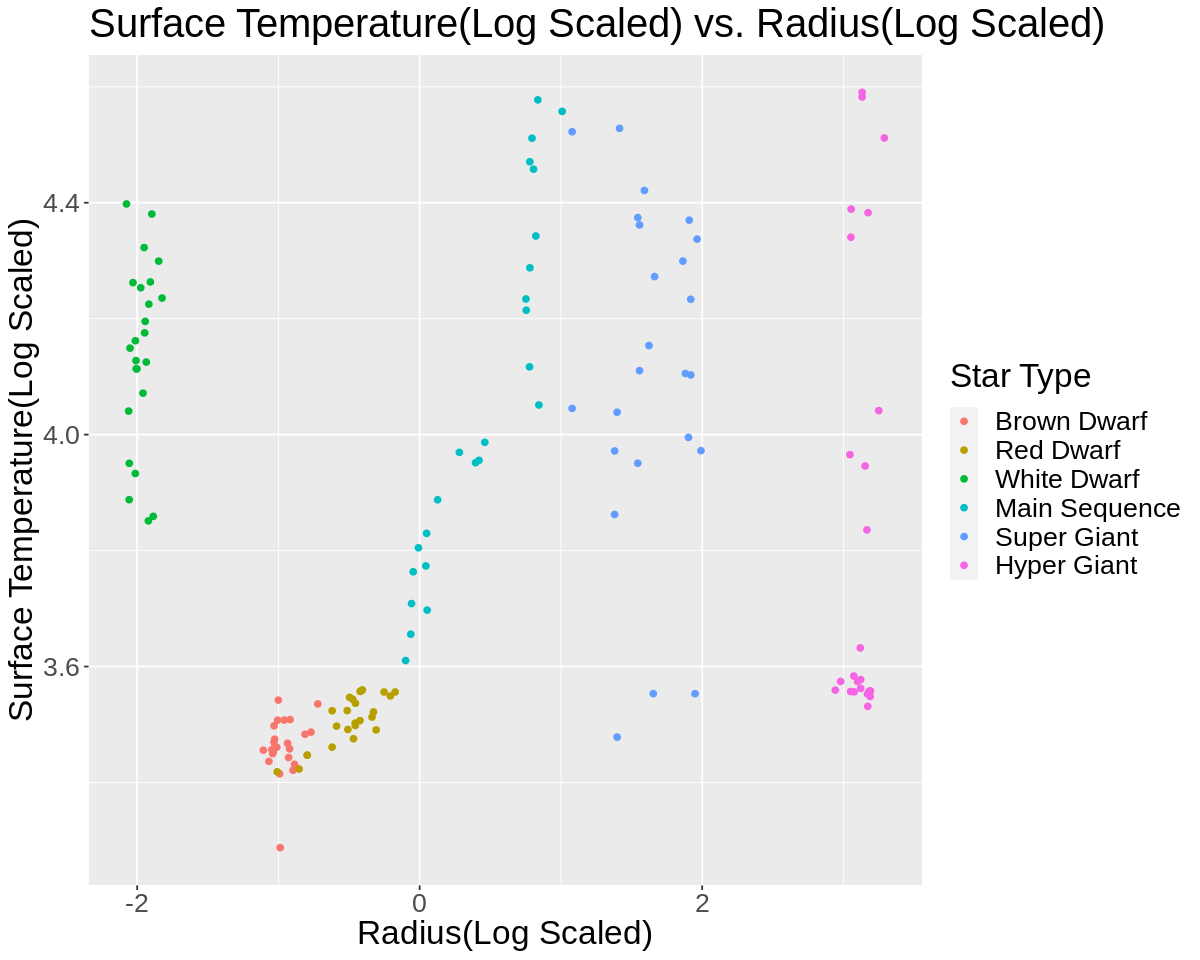

In [8]:
#Visualization of Temperature vs. Radius
star_plot_3 <- star_train %>%
    ggplot(aes(x = radius, y = temperature, color = star_type)) + 
    geom_point() +
    ggtitle("Surface Temperature(Log Scaled) vs. Radius(Log Scaled)") +
    labs(x = "Radius(Log Scaled)", y = "Surface Temperature(Log Scaled)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot_3

**Figure 3**

Based off of figure 3, there is a Strong positive non-linear relationship between Temperature and Radius for Brown Dwarfs, Red Dwarfs, and Main Sequence stars but no relationship for the rest of the star types.

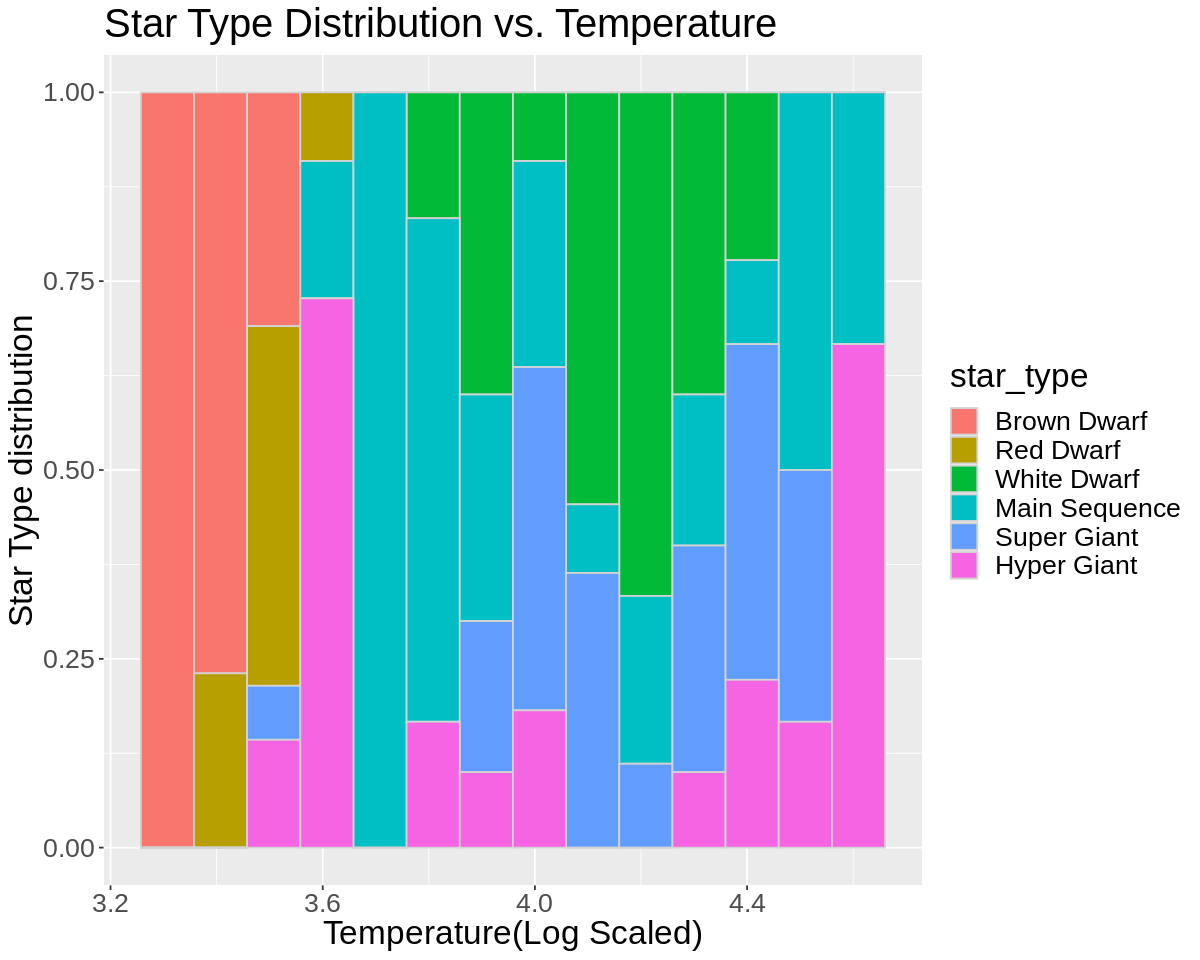

In [9]:
#Plot to see distribution of star type and temperature
star_temp_plot <- star_train %>%
    ggplot(aes(x = temperature, fill = star_type)) +
    geom_histogram(position = "fill", color = "lightgrey", bins = 14) +
    ggtitle("Star Type Distribution vs. Temperature") +
    labs(x = "Temperature(Log Scaled)", y = "Star Type distribution", color = "Star Type") +
    theme(text = element_text(size = 20))

star_temp_plot

**Figure 4**

Based off of Figure 4, there is too much star type variability for temperature. Temperatures from 3.4 to 3.6 and from around 3.8 to 5 include up to 2-4 different star types.

**Conclusion from Exploratory Data Analysis**

From Table 1, Figure 1, 3, and 4, it is possible that temperature may not be a good predictor by causing some observations to be classified incorrectly. Luminosity and radius remain good predictors. In the following, we build a model with temperature and a model without temperature to compare accuracies.

**Performing Data Analysis**

We will create two models in for our data analysis and we will pick the model with the best accuracy when applying cross validation as the model which we will use to predict the star type of stars in the test set. We will use a 10 fold cross validation throughout our data analysis since it will be a good amount of folds to determine good accuracies for various K values and also won't be too slow. We will test K values from 1 to 20 in our data analysis.

In [10]:
#Star Vfold to apply cross-validation
star_vfold <- vfold_cv(star_train, v = 10, strata = star_type)
k_vals <- tibble(neighbors = seq(1,20))

Now lets create the model which includes Temperature. We will build a model specification, create a recipe where we predict stars using the star_train dataset and luminosity, radius, and temperature to predict the star type. We will put everything together in a workflow and use cross validation to find the best K value.

In [11]:
#K-nearest neighbor model specification: pre cross-validation
knn_spec_temp <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Recipe for star data and standardization
star_recipe_temp <- recipe(star_type ~ radius + luminosity + temperature, data = star_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#Put together everything into a workflow
star_fit_temp <- workflow() %>%
    add_recipe(star_recipe_temp) %>%
    add_model(knn_spec_temp) %>%
    tune_grid(resamples = star_vfold, grid = k_vals)

# #Collect the summary of our cross-validation
star_summary_temp <- star_fit_temp %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

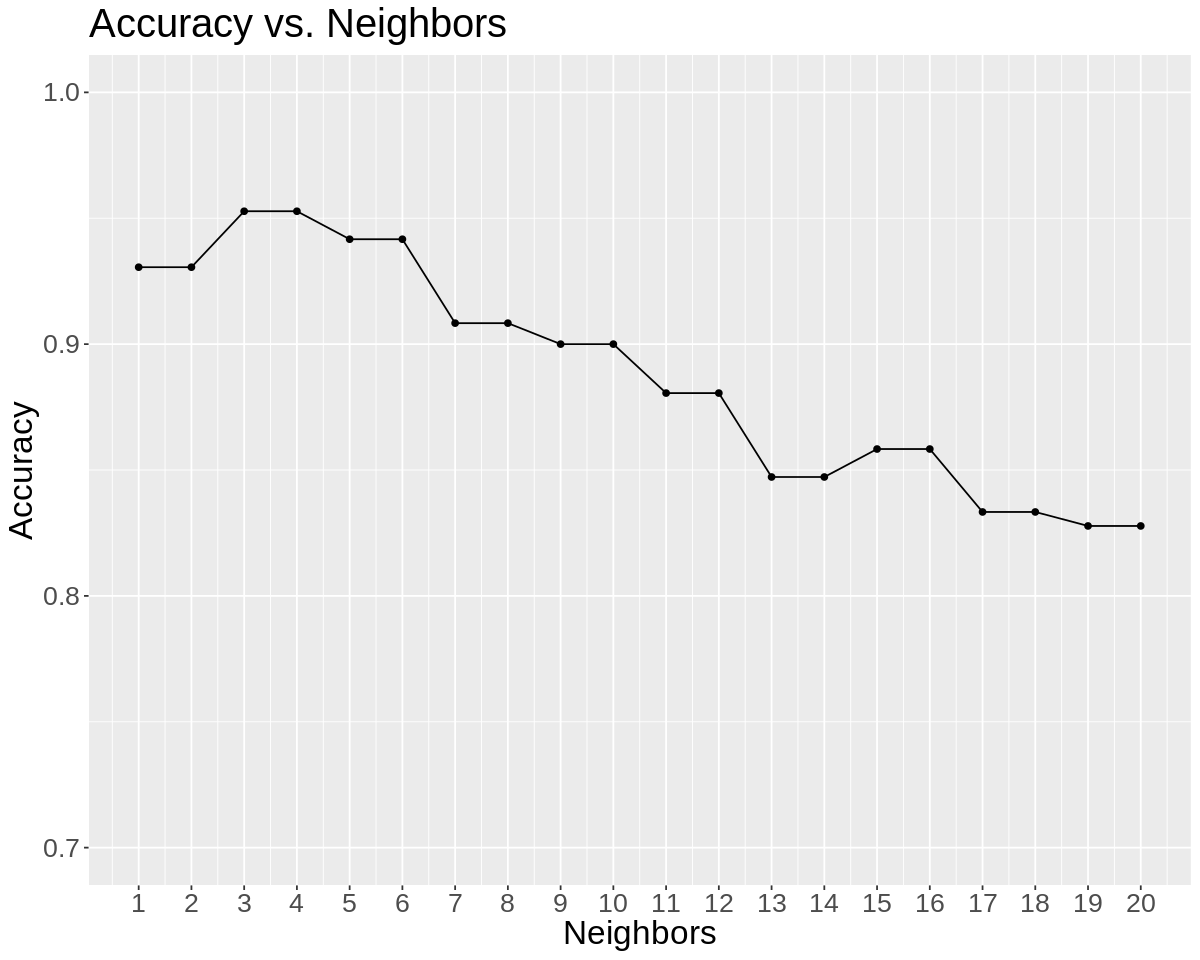

In [12]:
#Plot of accuracy vs. neighbors  
star_accuracy_plot <- star_summary_temp %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    ggtitle("Accuracy vs. Neighbors") +
    labs(x = "Neighbors", y = "Accuracy") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:20) +
    ylim(0.7,1)

star_accuracy_plot

**Figure 5**

After visualizing accuracies for k values between 1 to 20, we can see that the optimal k value is 5. So lets extract that k value.

In [13]:
#Extracts best K value
k_min <- star_summary_temp %>%
    arrange(desc(mean)) %>% 
    slice(1) %>%
    select(neighbors) %>%
    pull()

k_min

[1] 3

Now lets retrain our model by making a new model specification with the best k value and apply cross validation to determine accuracy

In [14]:
#K-nearest neighbor model specification: pre cross-validation
knn_spec_temp <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Put together everything into a workflow
star_fit_temp <- workflow() %>%
    add_recipe(star_recipe_temp) %>%
    add_model(knn_spec_temp) %>%
    fit_resamples(resamples = star_vfold)

# #Collect the summary of our cross-validation
star_summary_temp <- star_fit_temp %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

star_summary_temp

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.9527778,10,0.01376488


**Table 2**

Table 2 shows us that our model is very good at predicting star type but to test our hypothesis we want to see if we can create a better model by excluding temperature as a predictor. Lets create our new model by specifying a new model specification, a new recipe where we use radius and luminosity to predict the star type and do cross validation to get the best k value.

In [15]:
#K-nearest neighbor model specification: pre cross-validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Recipe for star data and standardization
star_recipe <- recipe(star_type ~ radius + luminosity, data = star_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#Put together everything into a workflow
star_fit <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = star_vfold, grid = k_vals)

# #Collect the summary of our cross-validation
star_summary <- star_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

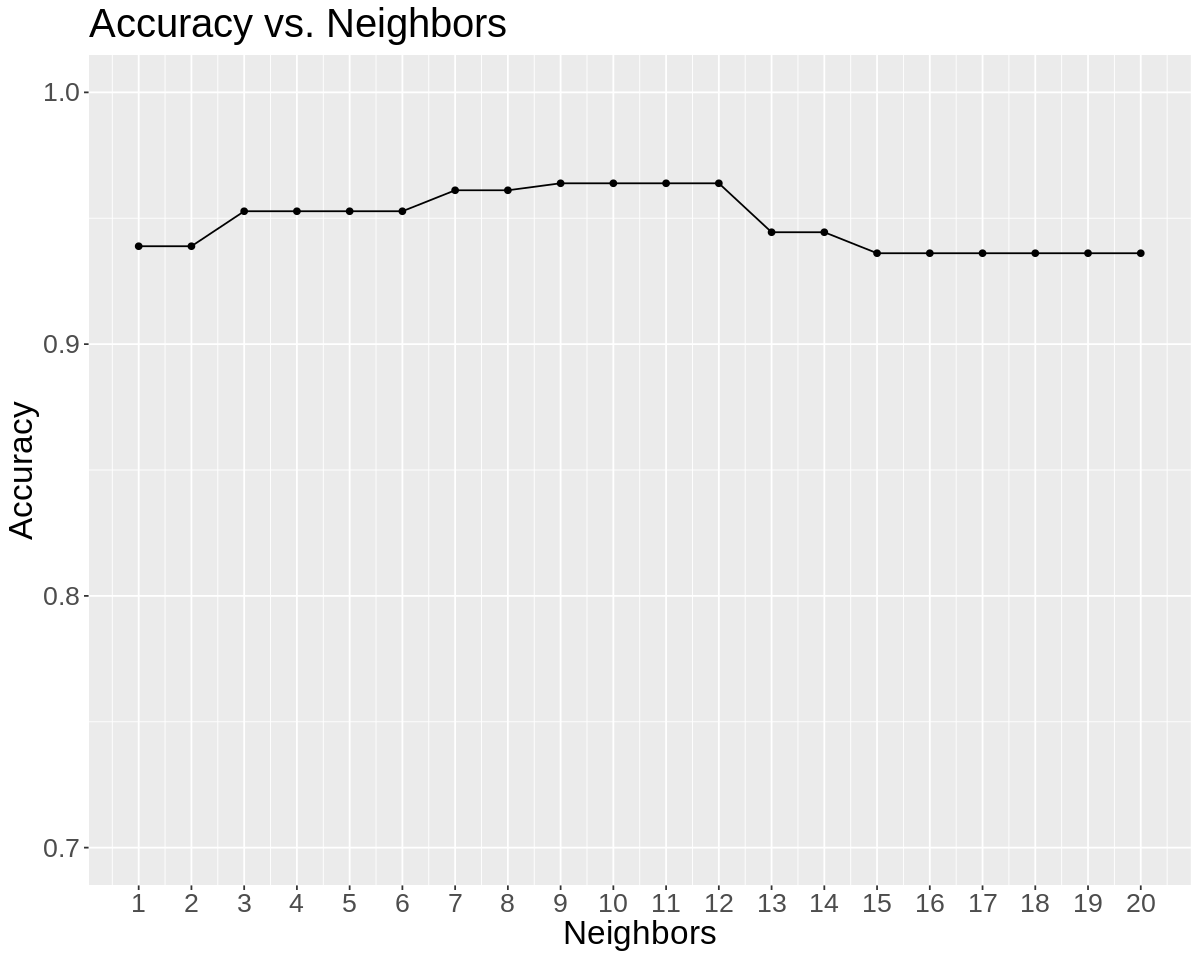

In [16]:
#Plot of accuracy vs. neighbors  
star_accuracy_plot <- star_summary %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    ggtitle("Accuracy vs. Neighbors") +
    labs(x = "Neighbors", y = "Accuracy") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:20) +
    ylim(0.7,1)

star_accuracy_plot

**Figure 6**

Plot of accuracy vs. neighbors for this model shows us that k = 3 is the best k value so lets extract it.

In [17]:
#Best K value
k_min <- star_summary %>%
    arrange(desc(mean)) %>% 
    slice(1) %>%
    select(neighbors) %>%
    pull()

k_min


[1] 9

Now lets retrain our model by using our optimal k value and use cross validation to determine what our accuracy is for this new model.

In [18]:
#Retrained model with new k value 
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Fit our model using a workflow and obtain accuracy using cross-validation
star_best_accuracy <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_best_spec) %>%
    fit_resamples(resamples = star_vfold) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

star_best_accuracy

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.9638889,10,0.01759259


**Table 3**

From Table 2 and 3, we can clearly see that our model which excludes temperature has a higher accuracy even though it's only around 1%. Since our new model is slightly better we will use that on our test dataset.

Lets fit our model onto the training data and use it to predict the star type for stars in our test data set and see what the accuracy is

In [19]:
#Fit the model onto training set
star_best_fit <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_best_spec) %>%
    fit(data = star_train) 

#Predict star type for the test data set using our model
star_predictions <- star_best_fit %>%
    predict(star_test) %>%
    bind_cols(star_test)

In [20]:
#Obtain the accuracy for the model
star_metrics <- star_predictions %>%
    metrics(truth = star_type, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

star_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.96875


**Table 4**

Table 4 shows us our model is around 96.8% accurate. Now lets use a confusion matrix to see where our model made mistakes.

In [21]:
#Create a confusion matrix for our predictions
star_conf_mat <- star_predictions %>%
    conf_mat(truth = star_type, estimate = .pred_class)

star_conf_mat

               Truth
Prediction      Brown Dwarf Red Dwarf White Dwarf Main Sequence Super Giant
  Brown Dwarf            16         2           0             0           0
  Red Dwarf               0        14           0             0           0
  White Dwarf             0         0          16             0           0
  Main Sequence           0         0           0            15           0
  Super Giant             0         0           0             1          16
  Hyper Giant             0         0           0             0           0
               Truth
Prediction      Hyper Giant
  Brown Dwarf             0
  Red Dwarf               0
  White Dwarf             0
  Main Sequence           0
  Super Giant             0
  Hyper Giant            16

**Table 5**

Our model predicted Brown Dwarfs, White Dwarfs, Super Giants and Hyper Giants flawlessly but misclassified a few Red Dwarfs and one Main Sequence star but overall our model is looking very good. Lets create a visualization to show how our model classifies star based on regions of a plot for luminosity vs. radius.

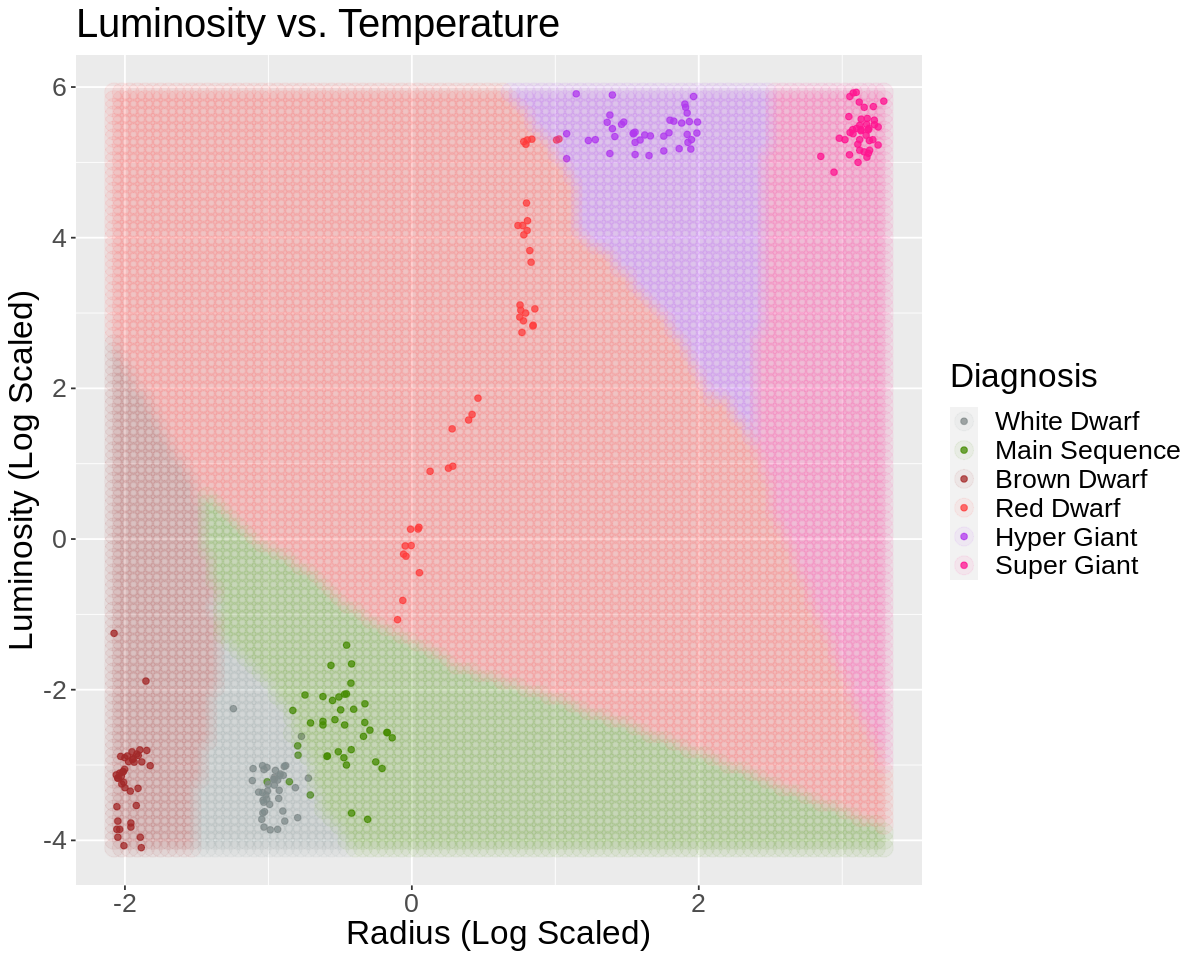

In [22]:
# create the grid of Luminosity/Radius vals, and arrange in a data frame
lum_grid <- seq(min(star_data$luminosity), 
                max(star_data$luminosity), 
                length.out = 100)
rad_grid <- seq(min(star_data$radius), 
                max(star_data$radius), 
                length.out = 100)
asgrid <- tibble(expand.grid(luminosity = lum_grid, 
                                radius = rad_grid))

#Make predictions for the observations in grid
knnPredGrid <- predict(star_best_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

#A plot of luminosity vs. Temperature using our original dataset where each grid is classified as a star. 
wkflw_plot <-
  ggplot() +
  geom_point(data = star_data, 
             mapping = aes(x = radius, 
                           y = luminosity, 
                          color = star_type), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = radius, 
                           y = luminosity, 
                           color = Class), 
             alpha = 0.06, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Radius (Log Scaled)", 
       y = "Luminosity (Log Scaled)") +
  scale_color_manual(labels = c("White Dwarf", "Main Sequence", "Brown Dwarf", "Red Dwarf", "Hyper Giant", "Super Giant"), 
                     values = c("azure4", "chartreuse4", "brown", "brown1", "darkorchid2", "deeppink1")) +
theme(text = element_text(size = 20)) + 
    ggtitle("Luminosity vs. Temperature")

wkflw_plot

**Figure 7**

Now lets create a bar graph where we visualize the proportionality of correct vs. incorrectly predicted stars for each star type.

`summarise()` regrouping output by 'star_type' (override with `.groups` argument)



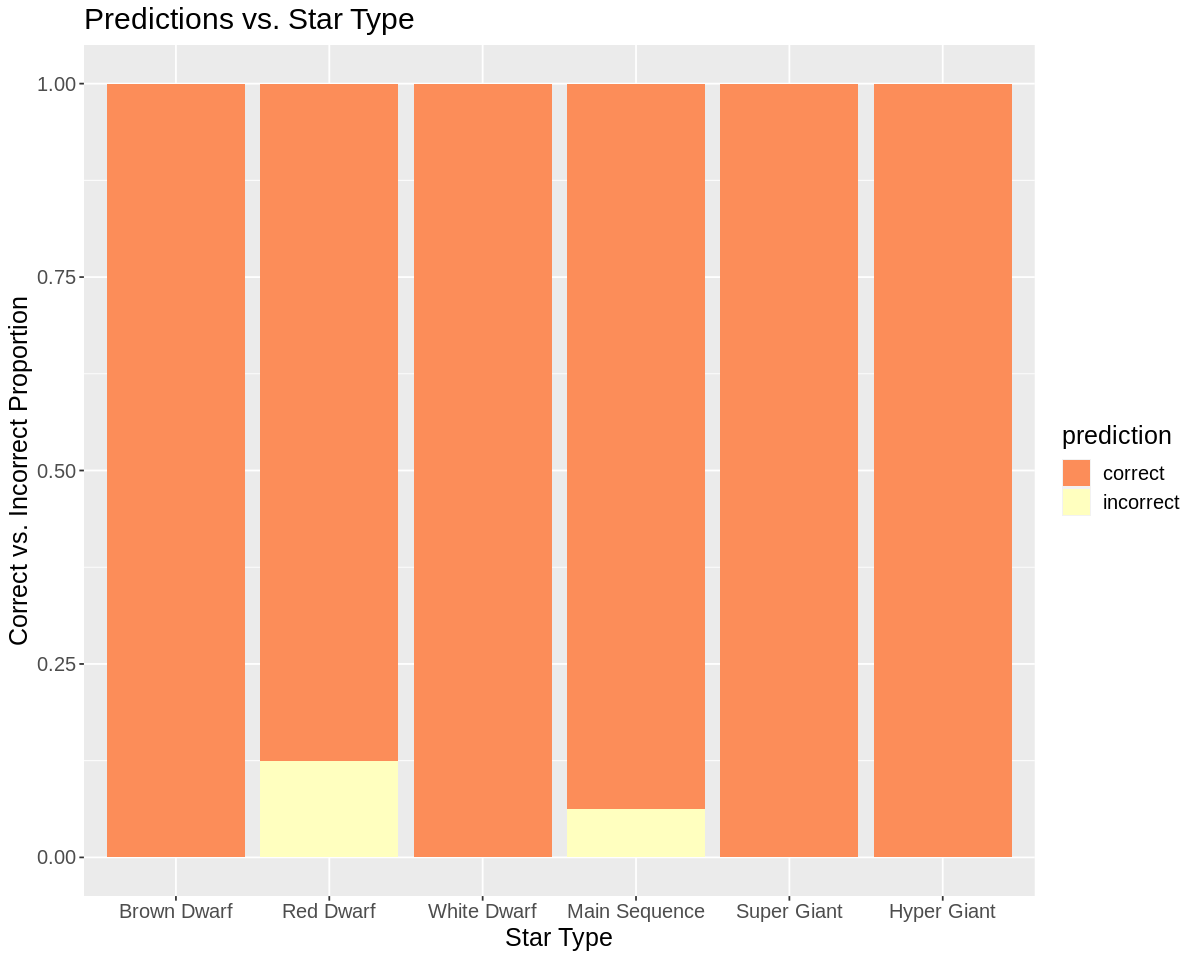

In [23]:
#Plot showing distribution of each star types incorrect vs correctly predicted stars
star_accuracy <- star_best_fit %>%
    predict(star_test) %>%
    bind_cols(star_test) %>%
    mutate(prediction = ifelse(.pred_class == star_type, "correct", "incorrect")) %>%
    group_by(star_type, prediction) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = star_type, y = n, fill = prediction)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "RdYlBu") +
    ggtitle("Predictions vs. Star Type") +
    labs(x = "Star Type", y = "Correct vs. Incorrect Proportion", color = "Predictions") +
    theme(text = element_text(size = 15))

star_accuracy

**Figure 8**

**Discussion**
 
Our final model yielded an accuracy of 96.9% on the test data, using the predictors luminosity and radius. Initially, we planned on using temperature as a predictor too but we noticed a lot of overlapping temperature values across star types (figure 4), we realized it could affect our overall accuracy. We hypothesized that temperature could potentially limit the accuracy of the classifier and had a higher chance of incorrectly classifying a star type. We tested our theory by making two models, one including temperature and one not including it. With temperature, accuracy was 95.5% and 96.7% without it. Even though we were able to obtain such a high accuracy with the temperature and it’s by no means a bad model, in order to optimize accuracy we decided it would be a better idea to stick with luminosity and radius. 

In our final model,  most of the stats were accurately predicted with the exception of a Main Sequence (predicted as a Super Giant) and a few Red Dwarfs (predicted as Brown Dwarfs). Looking at the luminosity vs radius graph (figure 7), this would be expected because some of these stars share similar radius and luminosity to the other stars, and they neighbour each other very closely on the graph. 

To evaluate the accuracy of the predictors, researchers are then able to confidently and efficiently classify stars. With a working classifier, researchers can expend their energy elsewhere to further scientific understanding of stars. The classifier also holds educational value to students by emphasizing and visualizing which predictors have a larger influence on a star’s type. The impact the findings can have is that we will create a model which will not only make it easier to classify star type, but it will help support the hypothesis of astronomers regarding luminosity, radius, and temperature being the key factors for star type classification.

Future analyses could aim to quantify star colour to incorporate it into our analysis. Currently, we are unable to use star colour as a predictor because it is a qualitative variable. By implementing colourimetry methods, star colour could be included as a predictor. Further questions include: what is the most effective way to utilize star colour as a predictor? Can star colour improve our model when classifying star type? Can star colour be classified using our predictors? We can also use clustering to determine new star types. There may be new star types that are yet to be discovered when we analyze clusterings of the graphs plotted by the predictors. Questions following that include: Why are there 6 star types currently? Are some star types really similar that they can be considered one star type? From our current data and observations, are there more star types than we realize?

Another question we hope to find out in the future is how we could decide the variables we will use as predictors. If variables like temperature or color are fundamental properties of our target predicting variable but does not help much in our classifier, should we keep it or get rid of it? If we wanted to keep it, is there any way we could reduce the weight of it while predicting? To what degree should we keep them in our classifier or do we completely discard them?

The results matched our expectations because we were expecting fairly accurate results because these are the predictors used by astronomers. Although temperature is a useful predictor which astronomers use, in our model it did not have as big of an impact, compared to luminosity and radius when it came to star type, while doing research we learned that temperature has a bigger role when predicting spectral class(seperate from star type). We were able to build an effective model using the 3 predictors astronomers use but after careful data analysis we decided to use radius and luminosity but both models are incredibly accurate. Overall our final model ended up being able to effectively, consistently and accurately predict new star’s types. 


**References**

Baidya, D. (2020). Star dataset to predict star types. https://www.kaggle.com/datasets/deepu1109/star-dataset/code

Hertzsprung-Russell Diagram: Cosmos. Hertzsprung-Russell Diagram | COSMOS. (n.d.). Retrieved April 3, 2022, from - - https://astronomy.swin.edu.au/cosmos/h/hertzsprung-russell+diagram

LeBoeuf-Little, N. How does the H-R diagram explain the life cycle of a Star? Sciencing. Retrieved April 3, 2022, from https://sciencing.com/hr-explain-life-cycle-star-5507250.html

A note on the spectral atlas and Spectral Classification. Spectral Classification. (n.d.). Retrieved April 3, 2022, from https://lweb.cfa.harvard.edu/~pberlind/atlas/htmls/note.html 